In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

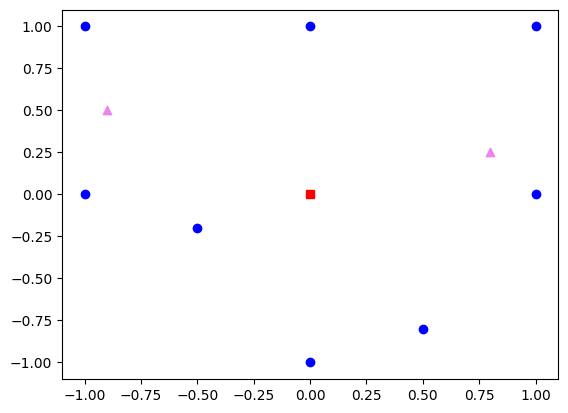

In [2]:
num_customers = 8
xc = [0, -1, 0, 1, -1, 1, -0.5, 0, 0.5]
yc = [0, 1, 1, 1, 0, 0, -0.2, -1, -0.8]

num_stations = 2
num_freq = 3

c_xc = [-0.9, 0.8]
c_yc = [0.5, 0.25]
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
plt.scatter(c_xc, c_yc, c='violet', marker='^')
xc.extend(list(np.repeat(c_xc, num_freq)))
yc.extend(list(np.repeat(c_yc, num_freq)))

xc.append(0)
yc.append(0)

In [4]:
np.random.seed(0)
V = [v_i for v_i in range(1, num_customers+1)]
Fp = [v_i for v_i in range(num_customers+1, num_customers+1+num_stations*num_freq)]
Vs = V+Fp
Vs = [0] + Vs + [max(Vs)+1]
A = [(i,j) for i in Vs for j in Vs if i!=j]
# assume d=t, h=1
h = 1
d = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
t = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
s = [0 for i in Vs]
# customer demand
q = {i: 1 for i in V}
q.update({i: 0 for i in Vs if not i in V})

# max time 
H = 5
tw = {i: (0, H) for i in Vs}
e = {i: tw[i][0] for i in Vs}
l = {i: tw[i][1] for i in Vs}

# max bettery and capacity
Q = 3
C = 100
g = 1
M = l[0] + g*Q

# weighted obj parameters
alpha = 1
beta = 1

In [5]:
model = gp.Model("EVRPTW")

x = model.addVars(A, vtype=GRB.BINARY, name='x')
tau = model.addVars(Vs, vtype=GRB.CONTINUOUS, lb=0, ub=H)
u = model.addVars(Vs, vtype=GRB.CONTINUOUS, lb=0, ub=C)
y = model.addVars(Vs, vtype=GRB.CONTINUOUS, lb=0, ub=Q)

obj = gp.quicksum(alpha*x[0,j] for j in Vs[1:-1]) + gp.quicksum(beta*d[(i,j)] * x[i, j] for i in Vs[:-1] for j in Vs[1:] if i!=j)
model.setObjective(obj, GRB.MINIMIZE)

Set parameter Username
Set parameter LicenseID to value 2583716
Academic license - for non-commercial use only - expires 2025-11-14


In [6]:
# Constaints
model.addConstrs(gp.quicksum(x[i, j] for j in Vs[1:] if i != j) == 1 for i in V)
model.addConstrs(gp.quicksum(x[i, j] for j in Vs[1:] if i != j) <= 1 for i in Fp)
model.addConstrs(gp.quicksum(x[j, i] for i in Vs[1:] if i != j) -
                 gp.quicksum(x[i, j] for i in Vs[:-1] if i != j) == 0
                 for j in Vs[1:-1])
model.addConstrs(tau[i]+(t[(i,j)]+s[i])*x[i,j]-l[0]*(1-x[i,j]) <= tau[j] for i in [0]+V for j in Vs[1:] if i!=j)
model.addConstrs(tau[i]+t[(i,j)]*x[i,j] + g*(Q-y[i]) - M*(1-x[i,j])<=tau[j] for i in Fp for j in Vs[1:] if i!=j)
model.addConstrs(u[j]<=u[i]-q[i]*x[i,j]+C*(1-x[i,j]) for i in Vs[:-1] for j in Vs[1:] if i!=j)
model.addConstrs(y[j]<=y[i]-(h*d[(i, j)])*x[i,j] + Q*(1-x[i,j]) for j in Vs[1:] for i in V if i!=j)
model.addConstrs(y[j]<=Q-(h*d[(i, j)])*x[i,j] for j in Vs[1:] for i in [0]+Fp if i!=j)
model.addConstrs((e[j] <= tau[j] for j in Vs), name="10a")
model.addConstrs((tau[j] <= l[j] for j in Vs), name="10b")


                
model.addConstr(tau[0] == 0)
model.addConstr(u[0] == C)
model.addConstr(y[0] == Q)


<gurobi.Constr *Awaiting Model Update*>

In [7]:
X = np.zeros((len(Vs), len(Vs)), dtype=np.int32)

In [8]:
# Solve the model
model.optimize()
X = np.zeros((len(Vs), len(Vs)))
# Output results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(x)
    for i in Vs:
        for j in Vs:
            if i!=j and x[i,j].x > 0:
                X[i,j] = x[i,j].x
                print(i, j)
    # for i in range()
    # for k in range(num_vehicles):
    #     for i in range(num_customers + 1):
    #         for j in range(num_customers + 1):
    #             if x[i, j, k].x > 0.5:
    #                 print(f"Vehicle {k} travels from customer {i} to customer {j}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 696 rows, 288 columns and 2494 nonzeros
Model fingerprint: 0xad157136
Variable types: 48 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [3e-01, 2e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
Presolve removed 148 rows and 44 columns
Presolve time: 0.06s
Presolved: 548 rows, 244 columns, 3641 nonzeros
Variable types: 42 continuous, 202 integer (202 binary)
Found heuristic solution: objective 24.9791403

Root relaxation: objective 6.197350e+00, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [ ]:
X.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
actions = []
# Loop over the indices of the first row where vehicles leave the depot
for n in np.where(X[0] == 1)[0]:
    actions.extend([0, n])  # Add the first station visited
    index = np.where(X[n] == 1)[0]  # Find the next station from the current one
    
    while index.size > 0:
        if index.size > 1:  # If there's more than one station to go to, raise an error
            raise ValueError("Multiple stations visited at the same time, cannot determine sequence")
        
        n = index[0]  # Move to the next station
        actions.append(n)  # Append the next station to the actions list
        index = np.where(X[n] == 1)[0]  # Find the next station from the current station

actions  # This should give you the sequence of actions

[0, 9, 10, 1, 4, 6, 15, 0, 13, 3, 2, 15, 0, 14, 12, 5, 8, 7, 15]

In [56]:
for i in actions:
    print(f"Node {i}\tCapacity: {u[i].X:}\t Time: {tau[i].X:.3f}\t Battery: {y[i].X:.3f}")


Node 0	Capacity: 100.0	 Time: 0.000	 Battery: 3.000
Node 9	Capacity: 3.0	 Time: 1.030	 Battery: 1.616
Node 10	Capacity: 3.0	 Time: 2.413	 Battery: 3.000
Node 1	Capacity: 3.0	 Time: 2.923	 Battery: 2.077
Node 4	Capacity: 2.0	 Time: 3.923	 Battery: 1.077
Node 6	Capacity: 1.0	 Time: 4.461	 Battery: 0.539
Node 15	Capacity: 0.0	 Time: 5.000	 Battery: 0.000
Node 0	Capacity: 100.0	 Time: 0.000	 Battery: 3.000
Node 13	Capacity: 2.0	 Time: 0.838	 Battery: 1.614
Node 3	Capacity: 2.0	 Time: 3.000	 Battery: 2.000
Node 2	Capacity: 1.0	 Time: 4.000	 Battery: 1.000
Node 15	Capacity: 0.0	 Time: 5.000	 Battery: 0.000
Node 0	Capacity: 100.0	 Time: 0.000	 Battery: 3.000
Node 14	Capacity: 3.0	 Time: 0.838	 Battery: 2.162
Node 12	Capacity: 3.0	 Time: 1.676	 Battery: 2.478
Node 5	Capacity: 3.0	 Time: 2.518	 Battery: 2.482
Node 8	Capacity: 2.0	 Time: 3.461	 Battery: 1.539
Node 7	Capacity: 1.0	 Time: 4.000	 Battery: 1.000
Node 15	Capacity: 0.0	 Time: 5.000	 Battery: 0.000


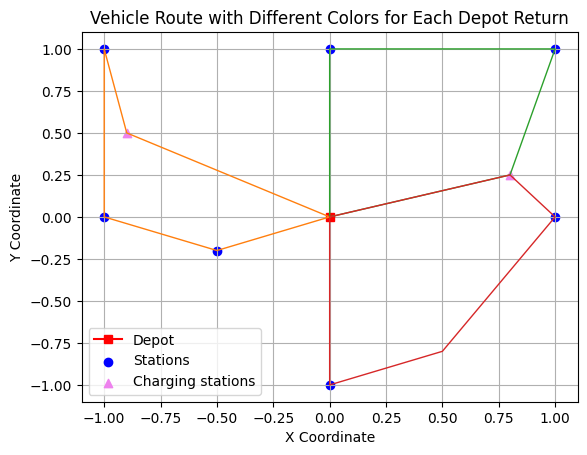

In [42]:
# Assuming xc and yc are the coordinates for each station/depot
# actions is the sequence of visited station indices from your previous code
# Plot the depot
plt.plot(xc[0], yc[0], c='r', marker='s', label='Depot')

# Plot the stations except the depot
plt.scatter(xc[1:num_customers], yc[1:num_customers], c='b', label='Stations')

# Plot additional points (like charging stations, etc.)
plt.scatter(c_xc, c_yc, c='violet', marker='^', label='Charging stations')


# Initialize variables for plotting route segments
current_segment = []

# Loop through the actions to plot each segment with a different color
for i, action in enumerate(actions):
    current_segment.append(action)
    
    # If the vehicle reaches the depot (action == 0) or it's the last action, plot the current segment
    if action == 0 or i == len(actions) - 1:
        # Get the x and y coordinates for the current segment
        segment_x = [xc[station] for station in current_segment]
        segment_y = [yc[station] for station in current_segment]
        
        # Plot the current segment with the current color
        plt.plot(segment_x, segment_y, linestyle='-', linewidth=1)
        
        # Reset the current segment after reaching the depot
        current_segment = [action]



        
# Add labels, legends, and show the plot
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Vehicle Route with Different Colors for Each Depot Return')
plt.grid(True)
plt.show()